# Student Performance Microbenchmark
Simple statistical queries about students in a Portuguese class.
This file is adapted to use numpy only without Spark.

In [1]:
EXPERIMENT = 'pac-student_performance-sparkless'
OUTPUT_DIR = f'./outputs/{EXPERIMENT}'
GENERATE = True

if GENERATE:
    print("GENERATE = True, so we will generate new samples.")
else:
    print("GENERATE = False, so we will load saved output from files rather than recomputing.")

import os
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

GENERATE = True, so we will generate new samples.


### Running PAC

In [2]:
from typing import Any, Callable, Dict, List, Tuple, Union

import numpy as np
import pandas as pd
from pandas import DataFrame
import concurrent.futures
import pyarrow as pa
import pyarrow.parquet as pq
import pickle
from numpy.random import laplace
from functools import reduce
import operator

In [3]:
### Mayuri's conversion functions between DP epsilon and PAC MI using posterior advantage for equivalence
def calc_posterior(mi, prior=0.5, prec = 100000):
    test_vals = [x / prec for x in range(1, prec)]
    max_t = None
    for t in test_vals:
        if t*np.log(t/prior)+(1-t)*np.log((1-t)/(1-prior)) <= mi:
            if  max_t is None or t > max_t:
                max_t = t
    return max_t

def dp_epsilon_to_posterior_success(epsilon):
    return 1 - 1./(1+np.exp(epsilon))

def dp_ps_to_epsilon(ps):
    return np.log(ps / (1-ps))

# example usage:
# dp_ps_to_epsilon(calc_posterior(1/256.))

In [4]:
### Data Setup
por_df = pq.read_table(f"./data/student_performance/student-por.parquet").to_pandas()
# drop last row
por_df = por_df.iloc[:-1] 
por_df.shape

(648, 33)

In [5]:
por_df['absences'].count()

648

In [6]:
true_result = por_df['absences'].agg(['count', 'sum', 'mean']).to_numpy()
true_result

array([ 648.        , 2371.        ,    3.65895062])

In [7]:
### Query Setup
SAMPLES = 512
assert SAMPLES % 2 == 0, "We need an even number of samples for paired sampling."
number_of_pairs = SAMPLES // 2

true_result = por_df['absences'].agg(['count', 'sum', 'mean']).to_numpy() # Save the true result of the query for later
number_of_contributing_rows = por_df['absences'].count()

def poisson_paired_sample(df: DataFrame) -> Tuple[DataFrame, DataFrame]:
    """
    This will select a subset of indices, where each index is selected with probability 0.5.
    The first result is the dataframe composed of the selected rows.
    The second result is the complement / the dataframe composed of the rows that were not selected.
    """
    indices = []
    for i in df.index:
        if np.random.choice([0, 1], p=[0.5, 0.5]):
            indices.append(i)
    not_indices = list(set(df.index) - set(indices))
    selected: DataFrame = df.iloc[indices]
    not_selected: DataFrame = df.iloc[not_indices]
    return (selected, not_selected)

def run_query(i: int) -> List[np.ndarray]:
    # i is not used for anything, just to satisfy the map function.
    # Returns two results each invocation as a result of paired sampling.
    results = []
    for temp_df in poisson_paired_sample(por_df):
        out_df = temp_df['absences'].agg(['count', 'mean'])  # run the query
        #out_df['count'] *= 2  # correct query result for the 50% subsampling
        #out_df['sum'] *= 2  # correct query result for the 50% subsampling
        results.append(out_df.to_numpy())
    return results

def generate_samples(laplace_lambda: float = 1.0, alpha: int = 10) -> List[np.ndarray]:
    # thresholding happens here for PAC -- if there are less than alpha samples
    # (with some Laplacian noise), then we don't subsample and return None.
    laplace_noise: float = np.random.laplace(scale=laplace_lambda)
    if number_of_contributing_rows + laplace_noise < alpha:  # if we don't get enough results from the query
        print("There are not enough rows contributing to the result for PAC to be meaningful.")
        return []
    
    out_np: List[np.ndarray] = []
    for i in range(number_of_pairs):
        out_np.append(run_query(i))
    out_np = reduce(operator.iconcat, out_np, [])
    # https://stackoverflow.com/a/45323085

    #with concurrent.futures.ThreadPoolExecutor() as executor:
    #    out_np: List[np.ndarray] = list(executor.map(run_query, range(number_of_pairs)))
    #    out_np = reduce(operator.iconcat, out_np, [])
    #    # https://stackoverflow.com/a/45323085

    return out_np

In [8]:
#s = generate_samples()
#s

In [9]:
# plot s[1] for all in list
#pd.DataFrame(s, columns=['count', 'mean']).hist("sum")

In [10]:
#pd.DataFrame(s, columns=['count', 'mean'])['sum']

In [11]:
# compute variance of pd.DataFrame(s, columns=['count', 'mean'])['sum']
#np.var(pd.DataFrame(s, columns=['count', 'mean'])['sum'])

In [12]:
### Compute PAC Noise
def updateDataFrame(vec: np.ndarray, df: DataFrame) -> DataFrame:
    """
    Update a DataFrame with a noisy output vector.
    """
    noisy_output_df = df.copy()
    noisy_output_df.loc[0] = vec
    return noisy_output_df

saved_pac_variables = []
# (out_np[0], fin_var, sqrt_total_var, pac_noise, pac_noises_to_add, pac_release)

def do_pac_and_release(out_np: List[np.ndarray],
                       max_mi: float = 1./4) -> np.ndarray:

    
    dimensions: int = len(out_np[0])

    out_np_2darr = [np.atleast_2d(o) for o in out_np] # make sure all the DF -> np.ndarray conversions result in 2d arrays

    est_y: np.ndarray = np.stack(out_np_2darr, axis=-1).reshape(dimensions, SAMPLES)

    # get the variance in each basis direction
    fin_var: np.ndarray = np.var(est_y, axis=1)  # shape (dimensions,)
    sqrt_total_var: np.floating[Any] = np.sum(np.sqrt(fin_var))

    pac_noise: np.ndarray = (1./(2*max_mi)) * sqrt_total_var * np.sqrt(fin_var)  # variance of the PAC noise
    pac_noises_to_add: np.ndarray = np.random.normal(loc=0, scale=pac_noise)
    # Add noise element-wise to the outputs
    pac_release = out_np[0] + pac_noises_to_add

    saved_pac_variables.append((max_mi, out_np[0], fin_var, sqrt_total_var, pac_noise, pac_noises_to_add, pac_release))
    
    return pac_release

# Update the DataFrame with the noisy output
# noisy_output_df = updateDataFrame(pac_release, out[0])

To replicate the experiment that runs for epsilon=0.01, 0.1, 1, 10
we use mi=1, 1/4, 1/16, 1/64, 1/256 in the hopes of encompassing a similar range.

In [13]:
MI_OPTIONS = [16., 4., 1., 1/4, 1/16, 1/64]#[16., 4., 2., 1., 1/4, 1/16, 1/32, 1/64]
EXPERIMENTS = 50

if GENERATE:
    # df = pd.DataFrame([], columns=['mi', 'count', 'sum', 'mean', 'var'])
    experiment_results = []

    for mi in MI_OPTIONS: 
        for e in range(EXPERIMENTS):
            out_np = generate_samples()
            noisy_output = do_pac_and_release(out_np, mi)
            # manually correct count = count * 2
            noisy_output[0] = noisy_output[0] * 2
            # manually add sum as count * mean
            noisy_output = [noisy_output[0], noisy_output[0] * noisy_output[1], noisy_output[1]]
            experiment_results.append([mi, *noisy_output])
        with open(f'{OUTPUT_DIR}/experiment_results.pkl', 'wb') as f:
            pickle.dump(experiment_results, f)
    
    df = pd.DataFrame(experiment_results, columns=['mi', 'count', 'sum', 'mean'])
    
    # Save the new data to outputs/...
    df.to_parquet(f'{OUTPUT_DIR}/pac_results.parquet')
    # with open(f'{OUTPUT_DIR}/experiment_results.pkl', 'wb') as f:
    #     pickle.dump(experiment_results, f)
else:
    df = pq.read_table(f"{OUTPUT_DIR}/pac_results.parquet").to_pandas()

    # with open('{OUTPUT_DIR}/experiment_results.pkl', 'rb') as f:
    #     experiment_results = pickle.load(f)

df.head()

,mi,count,sum,mean
0,16.0,666.653189,2551.628706,3.827520
1,16.0,627.080612,2068.486630,3.298598
2,16.0,660.010659,2468.877941,3.740664
3,16.0,597.500906,2334.094364,3.906428
4,16.0,657.901605,2370.394483,3.602962


In [14]:
### DEBUG: Save the variables from computing the PAC noises for later reverse engineering
if GENERATE:
    saved_pac_variables_df = pd.DataFrame(saved_pac_variables, columns=['mi', 'out_np_0', 'fin_var', 'sqrt_total_var', 'pac_noise', 'pac_noises_to_add', 'pac_release'])
    saved_pac_variables_df.to_parquet(f'{OUTPUT_DIR}/saved_pac_variables.parquet')
else:
    saved_pac_variables_df = pq.read_table(f"{OUTPUT_DIR}/saved_pac_variables.parquet").to_pandas()
saved_pac_variables_df.head()

,mi,out_np_0,fin_var,sqrt_total_var,pac_noise,pac_noises_to_add,pac_release
0,16.0,"[322.0, 3.7950310559006213]","[154.953125, 0.03751384271320148]",12.641702,"[4.917628686936953, 0.07651583827174184]","[11.326594477668666, 0.03248938252431702]","[666.6531889553373, 3.8275204384249384]"
1,16.0,"[318.0, 3.393081761006289]","[130.984375, 0.04244796720397445]",11.650870,"[4.166948267555308, 0.07501304778043197]","[-4.459693883265257, -0.09448411651296054]","[627.0806122334695, 3.2985976444933285]"
2,16.0,"[332.0, 3.7740963855421685]","[142.46875, 0.030512979179350468]",12.110707,"[4.517304095489353, 0.06610918858870721]","[-1.9946705913523508, -0.03343264313382303]","[660.0106588172953, 3.7406637424083455]"
3,16.0,"[304.0, 3.898026315789474]","[166.10546875, 0.03201652199631724]",13.067123,"[5.262861673744837, 0.07306629161972081]","[-5.249546896974644, 0.008401842233671075]","[597.5009062060507, 3.906428158023145]"
4,16.0,"[329.0, 3.6686930091185412]","[163.98046875, 0.030533215637469288]",12.980223,"[5.194314629253139, 0.07087914380430951]","[-0.04919729852783943, -0.06573101129648556]","[657.9016054029444, 3.6029619978220557]"


### Computing PAC Errors

In [15]:
# functions to calculate errors
def absolute_scaled_error(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return np.abs(est - actual)
def relative_error_percent(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return (np.abs(est - actual) / actual) * 100

In [16]:
OUTPUT_COLS = ['count', 'sum', 'mean']
ERROR_COLS = [*[f'absolute error {i}' for i in OUTPUT_COLS], *[f'relative error {i}' for i in OUTPUT_COLS]]

In [17]:
# compute errors for PAC (or import from saved file)
if GENERATE:
    errors_list = []
    for i, row in df.iterrows():
        mi = row['mi']
        r = row[OUTPUT_COLS].to_numpy()
        errors_list.append([mi, *absolute_scaled_error(r, true_result), *relative_error_percent(r, true_result)])
    pac_errors_df = pd.DataFrame(errors_list, columns=['mi', *ERROR_COLS])
    pac_errors_df.to_parquet(f"{OUTPUT_DIR}/pac_errors.parquet")  # overwrite saved
else:
    pac_errors_df = pq.read_table(f"{OUTPUT_DIR}/pac_errors.parquet").to_pandas()
pac_errors_df

,mi,absolute error count,absolute error sum,absolute error mean,relative error count,relative error sum,relative error mean
0,16.000000,18.653189,1.806287e+02,0.168570,2.878579,7.618250,4.607054
1,16.000000,20.919388,3.025134e+02,0.360353,3.228301,12.758894,9.848533
2,16.000000,12.010659,9.787794e+01,0.081713,1.853497,4.128129,2.233239
3,16.000000,50.499094,3.690564e+01,0.247478,7.793070,1.556543,6.763621
4,16.000000,9.901605,6.055174e-01,0.055989,1.528026,0.025538,1.530182
...,...,...,...,...,...,...,...
295,0.015625,5184.977113,1.321260e+05,25.904019,800.150789,5572.584219,707.963053
296,0.015625,11162.932562,1.762032e+06,163.689801,1722.674778,74315.977805,4473.681603
297,0.015625,14126.573903,2.638660e+05,14.360997,2180.026837,11128.892495,392.489488
298,0.015625,20041.330027,1.888216e+06,93.582990,3092.797844,79637.960878,2557.645622


In [18]:
# if GENERATE:
#     mean_df = df.groupby('mi').mean()[['count', 'sum', 'mean', 'var']]
#     std_df = df.groupby('mi').std()[['count', 'sum', 'mean', 'var']].abs()
#     mean_df, std_df

#     # save mean_df, std_df to parquet
#     mean_df.to_parquet('{OUTPUT_DIR}/pac-mean_df_student-por.parquet')
#     std_df.to_parquet('{OUTPUT_DIR}/pac-std_df_student-por.parquet')

### Computing DP Errors

### Analysis of PAC vs DP
- import the DP data
- create a dataframe (`all_df`) containing the query outputs
    - in this df, each output is the {mean, variance} aggregation over the 500 experiments, grouped by the type of privacy mechanism used (pac or dp) and privacy factor (mi or epsilon)
- create a dataframe in the same pattern containing the computed error for each privitized output

In [19]:
# Import Chai's saved data from running PipelineDP and use it to compare.
dp_results_df = pq.read_table(f"outputs/dp_results.parquet").to_pandas()

# compute sum from count and mean
dp_results_df['sum'] = dp_results_df['count'] * dp_results_df['mean']
dp_results_df = dp_results_df[['mi', 'count', 'sum', 'mean']]

dp_results_df

,mi,count,sum,mean
0,0.003906,660.050940,2598.420761,3.936697
1,0.003906,650.576555,2116.923464,3.253919
2,0.003906,657.433996,2228.459453,3.389632
3,0.003906,644.239500,2875.046901,4.462699
4,0.003906,634.495431,2520.045497,3.971732
...,...,...,...,...
895,16.000000,648.910033,2374.250822,3.658829
896,16.000000,649.067287,2372.422164,3.655125
897,16.000000,648.942620,2367.126350,3.647667
898,16.000000,649.044352,2379.478704,3.666127


In [20]:
# compute errors for DP (or import from saved file)
GENERATE_DP = True
if GENERATE_DP:
    errors_list = []
    for i, row in dp_results_df.iterrows():
        mi = row['mi']
        r = row[OUTPUT_COLS].to_numpy()
        errors_list.append([mi, *absolute_scaled_error(r, true_result), *relative_error_percent(r, true_result)])
    dp_errors_df = pd.DataFrame(errors_list, columns=['mi', *ERROR_COLS])
    dp_errors_df.to_parquet(f"outputs/dp_errors.parquet")  # overwrite saved
else:
    dp_errors_df = pq.read_table(f"outputs/dp_errors.parquet").to_pandas()
dp_errors_df

,mi,absolute error count,absolute error sum,absolute error mean,relative error count,relative error sum,relative error mean
0,0.003906,12.050940,227.420761,0.277747,1.859713,9.591766,7.590884
1,0.003906,2.576555,254.076536,0.405032,0.397616,10.716007,11.069609
2,0.003906,9.433996,142.540547,0.269318,1.455864,6.011832,7.360537
3,0.003906,3.760500,504.046901,0.803748,0.580324,21.258832,21.966633
4,0.003906,13.504569,149.045497,0.312781,2.084038,6.286187,8.548377
...,...,...,...,...,...,...,...
895,16.000000,0.910033,3.250822,0.000122,0.140437,0.137108,0.003325
896,16.000000,1.067287,1.422164,0.003825,0.164705,0.059982,0.104551
897,16.000000,0.942620,3.873650,0.011284,0.145466,0.163376,0.308394
898,16.000000,1.044352,8.478704,0.007176,0.161165,0.357600,0.196119


In [21]:
### Make one merged DF to compare results
all_df = pd.concat([  # we will call mi and epsilon the "factor" so that the schemas match
    #dp_results_df.assign(type='dp').rename(columns={'eps': 'factor'}),
    dp_results_df.assign(type='dp').rename(columns={'mi': 'factor'}),
    df.assign(type='pac').rename(columns={'mi': 'factor'})
])
all_df = all_df.groupby(['type', 'factor']).agg(['mean', 'var'])
all_df.columns = [' '.join(col).strip() for col in all_df.columns.values]  # Flatten the columns
#all_df.to_parquet(f"{OUTPUT_DIR}/all_results.parquet")  # Save the merged results
all_df

count mean     count var     sum mean       sum var  \
type factor                                                            
dp   0.003906    648.592845  6.045818e+01  2398.073832  8.634635e+04   
     0.007812    648.897605  2.688194e+01  2389.477508  3.990028e+04   
     0.015625    649.211672  1.530226e+01  2393.518288  1.589616e+04   
     0.062500    649.249789  5.904308e+00  2378.577932  3.755536e+03   
     0.250000    649.049285  7.038266e-01  2372.398562  8.077147e+02   
     1.000000    648.998183  1.466184e-02  2375.337267  1.758985e+01   
     2.000000    649.007585  2.109847e-02  2375.221984  2.088131e+01   
     4.000000    648.991005  1.273822e-02  2375.038740  1.595267e+01   
     16.000000   649.011175  1.554098e-02  2375.139964  1.788450e+01   
pac  0.015625    809.858810  1.674895e+08 -8648.052538  8.898975e+11   
     0.062500   1106.159805  8.792806e+06    55.194364  1.564751e+09   
     0.250000    688.861065  2.368152e+05  2741.149571  1.821312e+07   
     1.000000    635.933357  4.116987e+04  2431.058489  1.160527e+06   
     4.000000    645.220579  2.281073e+03  2357.882090  4.289845e+04   
     16.000000   648.383700  6.226287e+02  2350.466288  2.899106e+04   

                mean mean     mean var  
type factor                             
dp   0.003906    3.697400     0.202188  
     0.007812    3.683002     0.097899  
     0.015625    3.686918     0.038056  
     0.062500    3.663558     0.008563  
     0.250000    3.655199     0.001959  
     1.000000    3.660006     0.000042  
     2.000000    3.659775     0.000048  
     4.000000    3.659587     0.000038  
     16.000000   3.659629     0.000041  
pac  0.015625   15.209873  5176.245242  
     0.062500    5.491630   222.612259  
     0.250000    3.816910    19.547482  
     1.000000    3.773600     1.502518  
     4.000000    3.663330     0.097676  
     16.000000   3.624217     0.043566

In [22]:
### Make another merged df for the errors
errors_df = pd.concat([  # we will call mi and epsilon the "factor" so that the schemas match
    #dp_errors_df.assign(type='dp').rename(columns={'eps': 'factor'}), 
    dp_errors_df.assign(type='dp').rename(columns={'mi': 'factor'}),
    pac_errors_df.assign(type='pac').rename(columns={'mi': 'factor'})
])
errors_df = errors_df.groupby(['type', 'factor']).agg(['mean', 'var'])
# drop absolute * mean and relative * var columns from level 1
errors_df = errors_df.drop(columns=[('absolute error count', 'mean'), ('absolute error mean', 'mean'), ('relative error count', 'var'), ('relative error mean', 'var')])
errors_df.columns = [' '.join(col).strip() for col in errors_df.columns.values]  # flatten the columns

#errors_df.to_parquet(f"{OUTPUT_DIR}/all_errors.parquet")
errors_df

absolute error count var  absolute error sum mean  \
type factor                                                         
dp   0.003906               2.460359e+01               210.445378   
     0.007812               1.155811e+01               132.358552   
     0.015625               7.320963e+00                89.656606   
     0.062500               3.452589e+00                44.228509   
     0.250000               5.042486e-01                19.835353   
     1.000000               1.466184e-02                 5.012504   
     2.000000               2.109847e-02                 4.818485   
     4.000000               1.273822e-02                 4.740504   
     16.000000              1.554098e-02                 5.085376   
pac  0.015625               6.224130e+07            583137.818086   
     0.062500               2.840939e+06             29203.936146   
     0.250000               7.858170e+04              3230.969763   
     1.000000               1.238602e+04               889.540627   
     4.000000               6.571989e+02               156.515487   
     16.000000              2.290563e+02               133.763769   

                absolute error sum var  absolute error mean var  \
type factor                                                       
dp   0.003906             4.235214e+04                 0.099772   
     0.007812             2.254940e+04                 0.056959   
     0.015625             8.288853e+03                 0.019481   
     0.062500             1.837621e+03                 0.004262   
     0.250000             4.122751e+02                 0.000967   
     1.000000             1.121277e+01                 0.000021   
     2.000000             1.543418e+01                 0.000025   
     4.000000             9.729479e+00                 0.000016   
     16.000000            9.074661e+00                 0.000019   
pac  0.015625             5.430319e+11              1794.847535   
     0.062500             6.999481e+08                87.713826   
     0.250000             7.700716e+06                 5.411401   
     1.000000             3.567763e+05                 0.644163   
     4.000000             1.807701e+04                 0.035528   
     16.000000            1.116339e+04                 0.014856   

                relative error count mean  relative error sum mean  \
type factor                                                          
dp   0.003906                    0.923963                 8.875807   
     0.007812                    0.616826                 5.582394   
     0.015625                    0.472374                 3.781384   
     0.062500                    0.308224                 1.865395   
     0.250000                    0.175857                 0.836582   
     1.000000                    0.154041                 0.211409   
     2.000000                    0.155492                 0.203226   
     4.000000                    0.152933                 0.199937   
     16.000000                   0.156046                 0.214482   
pac  0.015625                 1567.474472             24594.593762   
     0.062500                  379.351640              1231.713882   
     0.250000                   61.095998               136.270340   
     1.000000                   25.985462                37.517530   
     4.000000                    6.171145                 6.601244   
     16.000000                   3.031330                 5.641660   

                relative error sum var  relative error mean mean  
type factor                                                       
dp   0.003906             7.533768e+01                  8.765752  
     0.007812             4.011178e+01                  5.541331  
     0.015625             1.474454e+01                  3.784209  
     0.062500             3.268834e+00                  1.787633  
     0.250000             7.333714e-01                  0.862863  
     1.000000             1.994572e-02    

In [23]:
#abs_error = errors_df.groupby('mi').mean()[['absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var']]
#rel_error = errors_df.groupby('mi').mean()[['relative error count', 'relative error sum', 'relative error mean', 'relative error var']]

#std_abs_error = errors_df.groupby('mi').std()[['absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var']]
#sample_mean_rel_error = errors_df.groupby('mi').mean()[['relative error count', 'relative error sum', 'relative error mean', 'relative error var']]

# save std_abs_error, sample_mean_rel_error to parquet
# std_abs_error.to_parquet('outputs/pac-std_abs_error_student-por.parquet')
# sample_mean_rel_error.to_parquet('outputs/pac-sample_mean_rel_error_student-por.parquet')

### Plotting Results

We are reproducing Table 14 from this paper: http://arxiv.org/abs/2109.10789

> TABLE 14: Experiments of the queries count, sum, mean, and var on the attribute Absences of the Portuguese education dataset containing 649 individuals (500 experiments per ε).

In [24]:
### Imports for matplotlib
import matplotlib as mpl
#import seaborn as sns
import matplotlib.pyplot as plt
#sns.reset_orig()

# Michael's matplotlib defaults
# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
#matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

In [25]:
import matplotlib.colors as mcolors

PAC_COLOR = 'tab:blue'
DP_COLOR = 'tab:red'

# Function to lighten a color by blending with white
def lighten_color(color, amount=0.3):
    rgba = mcolors.to_rgba(color)
    return tuple(np.clip(np.array(rgba[:3]) + amount, 0, 1)) + (rgba[3],)

# Create lighter colors
PAC_LIGHT = lighten_color(PAC_COLOR, 0.3)
DP_LIGHT = lighten_color(DP_COLOR, 0.3)

# create legend, use color squares
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
pac_dp_legend_handles = [
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP')
]

Reproduction of Table 14 (PAC)

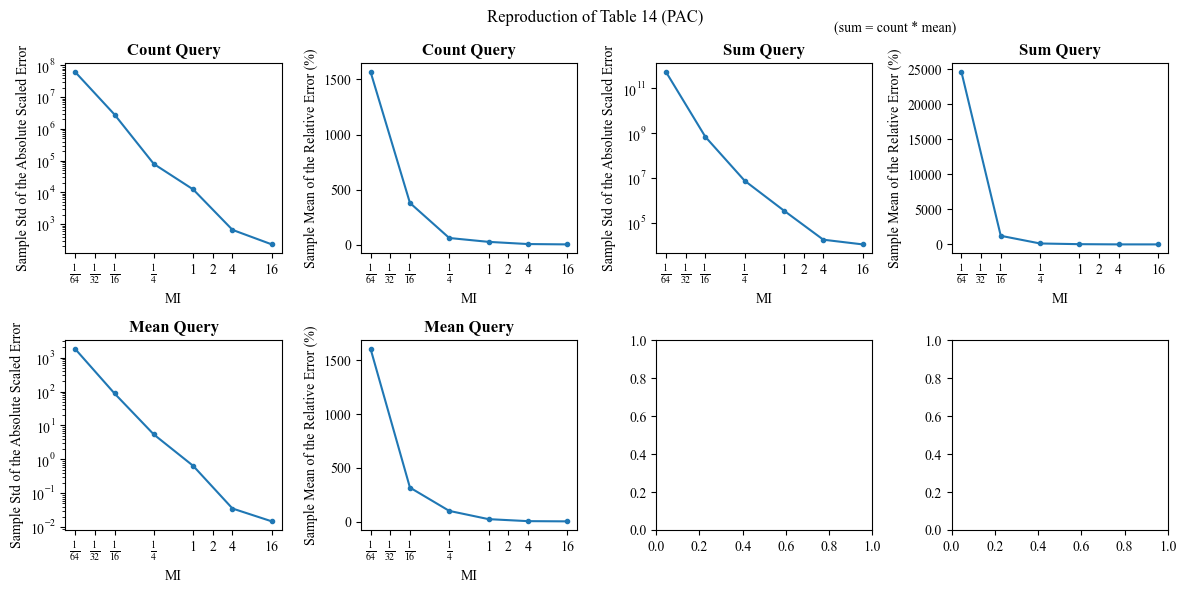

In [26]:
### Reproduction of Table 14 (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = OUTPUT_COLS
MI_OPTIONS = [1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'pac'
    d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)
             #label=query, marker='.')

    ax1.set_yscale('log')

    ax1.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xlabels)

    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc[TYPE].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)

    ax2.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)

    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

# add label in top left corner "sum = count * mean"
fig.text(0.75, 0.95, '(sum = count * mean)', ha='center', va='center')

fig.suptitle("Reproduction of Table 14 (PAC)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_pac.jpg", bbox_inches='tight')
plt.show()

Reproduction of Table 14 (DP)

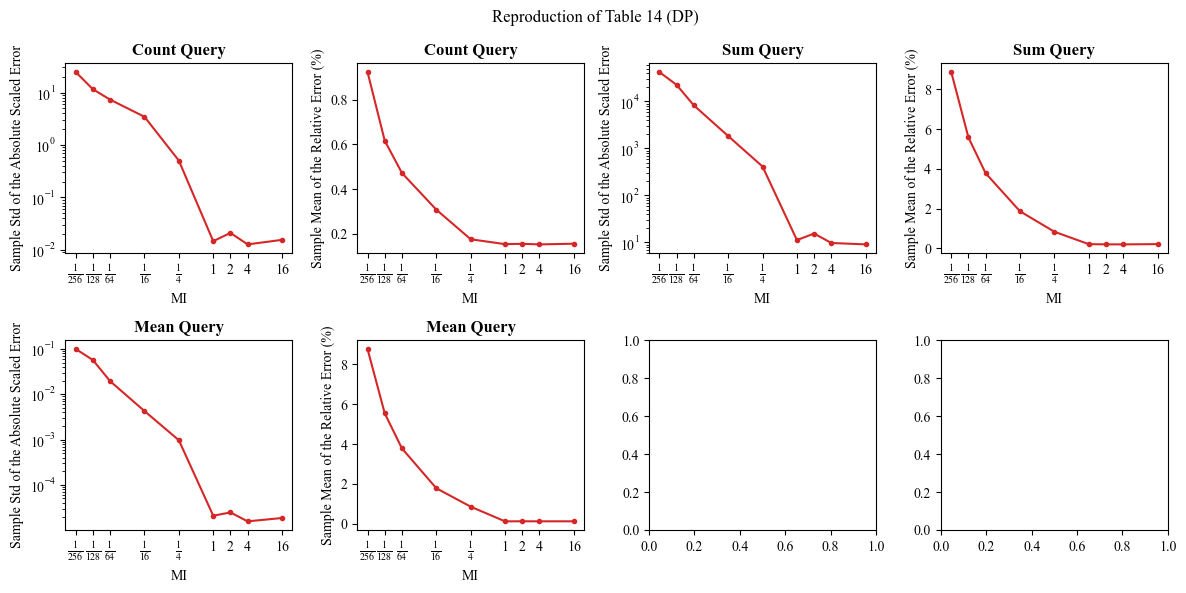

In [27]:
### Reproduction of Table 14 (DP)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = OUTPUT_COLS
MI_OPTIONS = [1/256, 1/128, 1/64, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'dp'
    d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
             #label=query, marker='.')
    
    ax1.set_yscale('log')

    ax1.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xlabels)

    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc[TYPE].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=DP_COLOR)

    ax2.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)

    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

fig.suptitle("Reproduction of Table 14 (DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_dp.jpg", bbox_inches='tight')
plt.show()

Both on the same axes, aligned

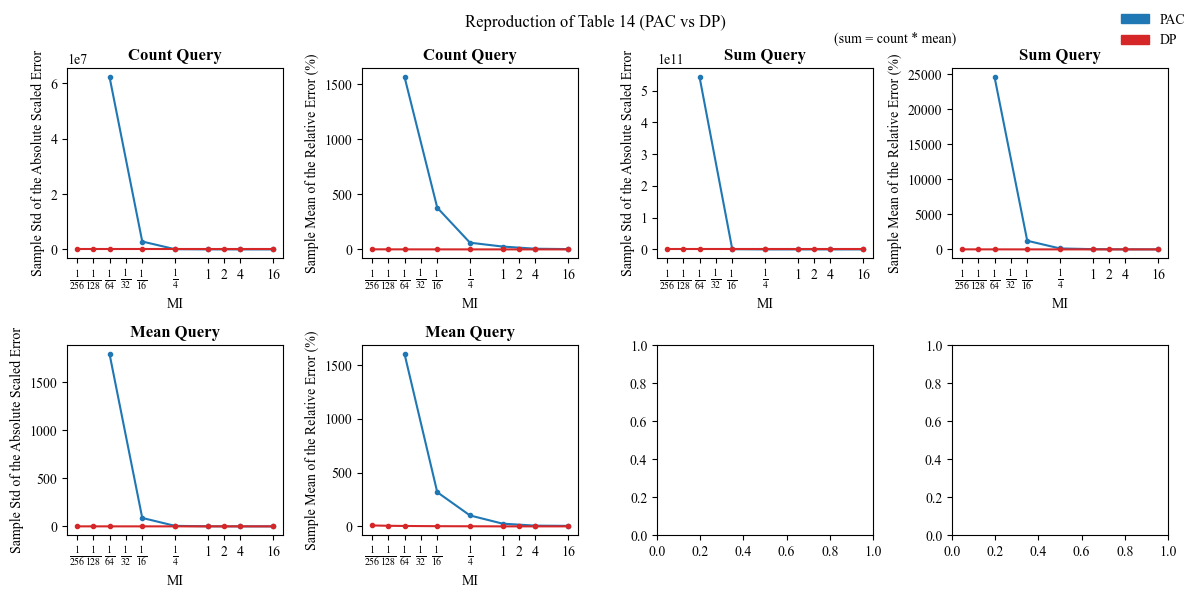

In [28]:
### Both on the same axes, aligned
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = OUTPUT_COLS
MI_OPTIONS = [1/256, 1/128, 1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    d = errors_df.loc['pac'].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)

    d = errors_df.loc['dp'].loc[:, f'absolute error {query} var']
    #print(d)
    ax1.plot(d.index, d, label=query, marker='.', color=DP_COLOR)

    ax1.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xlabels)

    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')
    ax1.set_xlabel('MI')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc['pac'].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)

    d = errors_df.loc['dp'].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
    
    ax2.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)

    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')
    ax2.set_xlabel('MI')

# add label in top left corner "sum = count * mean"
fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')

fig.legend(handles=pac_dp_legend_handles, loc='upper right', frameon=False)

fig.suptitle("Reproduction of Table 14 (PAC vs DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_pac_vs_dp.jpg", bbox_inches='tight')
plt.show()

In [29]:
pac_errors_df

,mi,absolute error count,absolute error sum,absolute error mean,relative error count,relative error sum,relative error mean
0,16.000000,18.653189,1.806287e+02,0.168570,2.878579,7.618250,4.607054
1,16.000000,20.919388,3.025134e+02,0.360353,3.228301,12.758894,9.848533
2,16.000000,12.010659,9.787794e+01,0.081713,1.853497,4.128129,2.233239
3,16.000000,50.499094,3.690564e+01,0.247478,7.793070,1.556543,6.763621
4,16.000000,9.901605,6.055174e-01,0.055989,1.528026,0.025538,1.530182
...,...,...,...,...,...,...,...
295,0.015625,5184.977113,1.321260e+05,25.904019,800.150789,5572.584219,707.963053
296,0.015625,11162.932562,1.762032e+06,163.689801,1722.674778,74315.977805,4473.681603
297,0.015625,14126.573903,2.638660e+05,14.360997,2180.026837,11128.892495,392.489488
298,0.015625,20041.330027,1.888216e+06,93.582990,3092.797844,79637.960878,2557.645622


In [30]:
dp_errors_df

,mi,absolute error count,absolute error sum,absolute error mean,relative error count,relative error sum,relative error mean
0,0.003906,12.050940,227.420761,0.277747,1.859713,9.591766,7.590884
1,0.003906,2.576555,254.076536,0.405032,0.397616,10.716007,11.069609
2,0.003906,9.433996,142.540547,0.269318,1.455864,6.011832,7.360537
3,0.003906,3.760500,504.046901,0.803748,0.580324,21.258832,21.966633
4,0.003906,13.504569,149.045497,0.312781,2.084038,6.286187,8.548377
...,...,...,...,...,...,...,...
895,16.000000,0.910033,3.250822,0.000122,0.140437,0.137108,0.003325
896,16.000000,1.067287,1.422164,0.003825,0.164705,0.059982,0.104551
897,16.000000,0.942620,3.873650,0.011284,0.145466,0.163376,0.308394
898,16.000000,1.044352,8.478704,0.007176,0.161165,0.357600,0.196119


# Additonal Extra Plotting

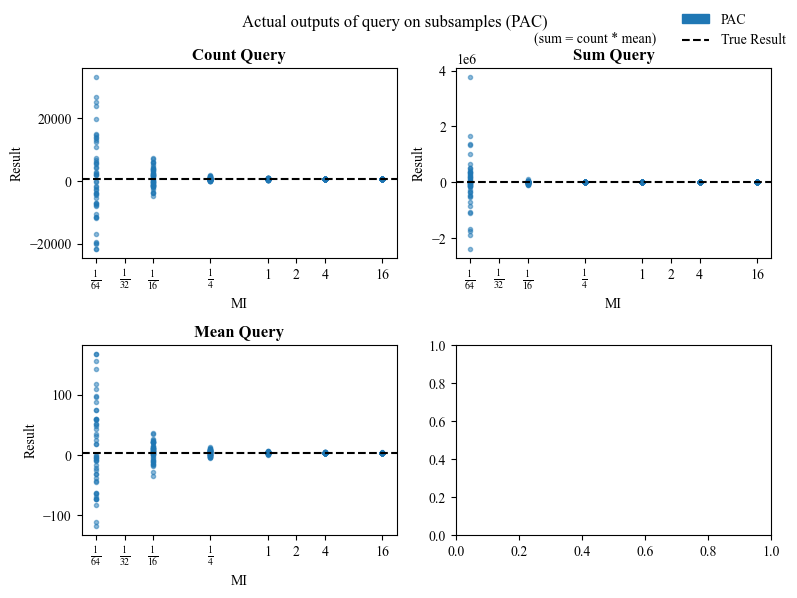

In [31]:
### Plotting the actual experiment outputs used (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = OUTPUT_COLS
MI_OPTIONS = [1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    TYPE = 'pac'
    ax.scatter(df['mi'], df[query], label=query, marker='.', alpha=0.5, color=PAC_COLOR)
    
    ax.axhline(y=true_result[i], color='black', linestyle='--', label='True Result')

    #for mi in MI_OPTIONS:
        #d = df.iloc[:, [0, i]].where(df['mi'] == mi).dropna()
        #ax.scatter(d.iloc[:, 0], d.iloc[:, 1], label=query, marker='.', alpha=0.5, color=PAC_COLOR)
        #ax.boxplot(d.iloc[:, 1], positions=[mi], widths=0.1, showfliers=False)
    
    ax.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Line2D([0], [0], color='black', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')

fig.suptitle("Actual outputs of query on subsamples (PAC)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_pac.jpg", bbox_inches='tight')
plt.show()

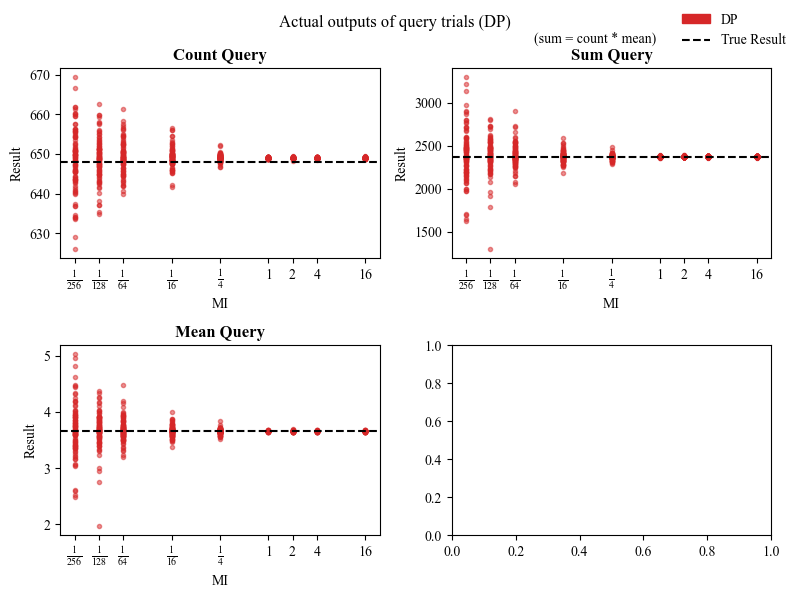

In [32]:
### Plotting the actual experiment outputs used (DP)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = OUTPUT_COLS
MI_OPTIONS = [1/256, 1/128, 1/64, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    TYPE = 'dp'

    ax.scatter(dp_results_df['mi'], dp_results_df[query], label=query, marker='.', alpha=0.5, color=DP_COLOR)
    ax.axhline(y=true_result[i], color='black', linestyle='--', label='True Result')

    ax.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP'),
    Line2D([0], [0], color='black', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')

fig.suptitle("Actual outputs of query trials (DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_dp.jpg", bbox_inches='tight')
plt.show()

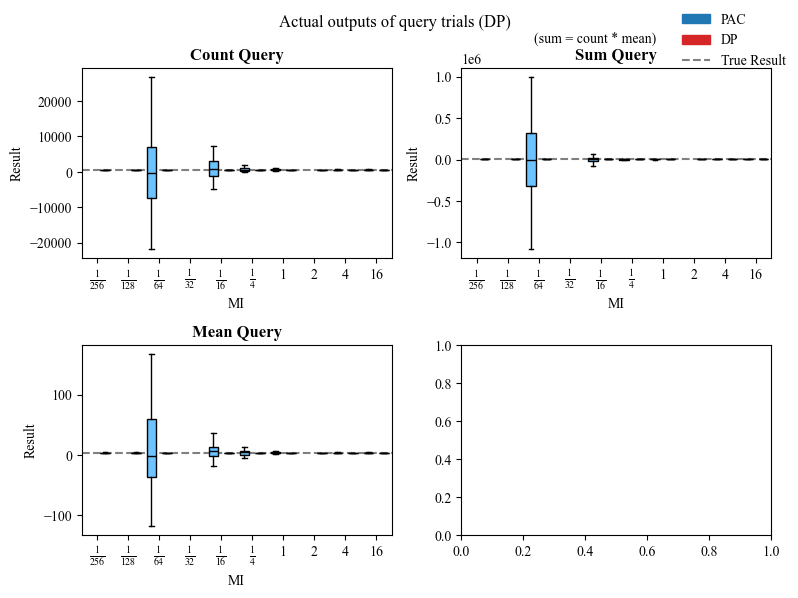

In [33]:
### Both, but with side by side fig, axs = plt.subplots(2, 2, figsize=(8, 6))
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = OUTPUT_COLS
MI_OPTIONS = [1/256, 1/128, 1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    ax.linewidth = 0.25

    # correct answer
    ax.axhline(y=true_result[i], color='gray', linestyle='--', label='True Result')

    for mi in MI_OPTIONS: # categorical variable
        position = MI_OPTIONS.index(mi) * 2

        TYPE = 'pac'

        pac_style = {
            'boxprops': dict(facecolor=PAC_LIGHT),
            'medianprops': dict(color='black')
        }
        
        # mi = mi and query is correct
        d = df[df['mi'] == mi][['mi', query]].iloc[:, 1].values
        ax.boxplot(d, positions=[position], widths=0.6, patch_artist=True, showfliers=False, **pac_style)

        position += 1
        TYPE = 'dp'

        dp_style = {
            'boxprops': dict(facecolor=DP_LIGHT),
            'medianprops': dict(color='black')
        }

        # mi = mi and query is correct
        d = dp_results_df[dp_results_df['mi'] == mi][['mi', query]].iloc[:, 1].values
        ax.boxplot(d, positions=[position], widths=0.6, patch_artist=True, showfliers=False, **dp_style)
    
    
    
    # override xticks, one for each pair of boxplots
    # the x axis is actually artificial here to plot both PAC and DP side by side
    xticks = [0.5+2*i for i in range(len(MI_OPTIONS))]
    ax.set_xticks(xticks)

    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in MI_OPTIONS]
    ax.set_xticklabels(xlabels)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP'),
    Line2D([0], [0], color='gray', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')

fig.suptitle("Actual outputs of query trials (DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_dp_vs_pac.jpg", bbox_inches='tight')
plt.show()


In [34]:
df.groupby('mi').var()

,count,sum,mean
mi,,,
0.015625,1.674895e+08,8.898975e+11,5176.245242
0.062500,8.792806e+06,1.564751e+09,222.612259
0.250000,2.368152e+05,1.821312e+07,19.547482
1.000000,4.116987e+04,1.160527e+06,1.502518
4.000000,2.281073e+03,4.289845e+04,0.097676
16.000000,6.226287e+02,2.899106e+04,0.043566


In [35]:
saved_pac_variables_df
# out_np_0 is the selected sample to which noise is added, [count, mean]
# fin_var is the variance in each basis direction [count, mean]
# sqrt_total_var is the square root of the sum of the variances used in calculating pac_noise
# pac_noises_to_add is the noise actually added to each basis direction (result of laplace(scale=pac_noise))
# pac_release is the final result after adding noise

,mi,out_np_0,fin_var,sqrt_total_var,pac_noise,pac_noises_to_add,pac_release
0,16.000000,"[322.0, 3.7950310559006213]","[154.953125, 0.03751384271320148]",12.641702,"[4.917628686936953, 0.07651583827174184]","[11.326594477668666, 0.03248938252431702]","[666.6531889553373, 3.8275204384249384]"
1,16.000000,"[318.0, 3.393081761006289]","[130.984375, 0.04244796720397445]",11.650870,"[4.166948267555308, 0.07501304778043197]","[-4.459693883265257, -0.09448411651296054]","[627.0806122334695, 3.2985976444933285]"
2,16.000000,"[332.0, 3.7740963855421685]","[142.46875, 0.030512979179350468]",12.110707,"[4.517304095489353, 0.06610918858870721]","[-1.9946705913523508, -0.03343264313382303]","[660.0106588172953, 3.7406637424083455]"
3,16.000000,"[304.0, 3.898026315789474]","[166.10546875, 0.03201652199631724]",13.067123,"[5.262861673744837, 0.07306629161972081]","[-5.249546896974644, 0.008401842233671075]","[597.5009062060507, 3.906428158023145]"
4,16.000000,"[329.0, 3.6686930091185412]","[163.98046875, 0.030533215637469288]",12.980223,"[5.194314629253139, 0.07087914380430951]","[-0.04919729852783943, -0.06573101129648556]","[657.9016054029444, 3.6029619978220557]"
...,...,...,...,...,...,...,...
295,0.015625,"[309.0, 3.585760517799353]","[143.25, 0.03084113510022467]",12.144326,"[4651.26086845694, 68.24778478014699]","[2607.488556360832, -25.830828401573434]","[5832.977112721664, -22.24506788377408]"
296,0.015625,"[337.0, 3.798219584569733]","[152.75, 0.034926435061499284]",12.546093,"[4961.912470304945, 75.03011622691362]","[-5594.46628078016, 163.55053167425706]","[-10514.93256156032, 167.34875125882678]"
297,0.015625,"[321.0, 3.5576323987538943]","[145.140625, 0.034235021083763084]",12.232459,"[4715.8312398150565, 72.42676048973763]","[7066.286951310349, 14.462314762904239]","[14774.573902620697, 18.019947161658134]"
298,0.015625,"[329.0, 3.486322188449848]","[160.9375, 0.030444715194683676]",12.860599,"[5220.832824764257, 71.80705565048639]","[-10025.665013553347, 93.75561871540089]","[-19393.330027106695, 97.24194090385073]"


In [36]:
tempdf = saved_pac_variables_df[['mi', 'fin_var']].copy()
tempdf.loc[:, 'fin_var'] = tempdf['fin_var'].apply(lambda x: x[1]) # just count
tempdf

/var/folders/xy/7x33379123vd25mldyhv3q7m0000gn/T/ipykernel_44233/3127143595.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  tempdf.loc[:, 'fin_var'] = tempdf['fin_var'].apply(lambda x: x[1]) # just count


,mi,fin_var
0,16.000000,0.037514
1,16.000000,0.042448
2,16.000000,0.030513
3,16.000000,0.032017
4,16.000000,0.030533
...,...,...
295,0.015625,0.030841
296,0.015625,0.034926
297,0.015625,0.034235
298,0.015625,0.030445


<Axes: title={'center': 'fin_var'}, xlabel='mi'>

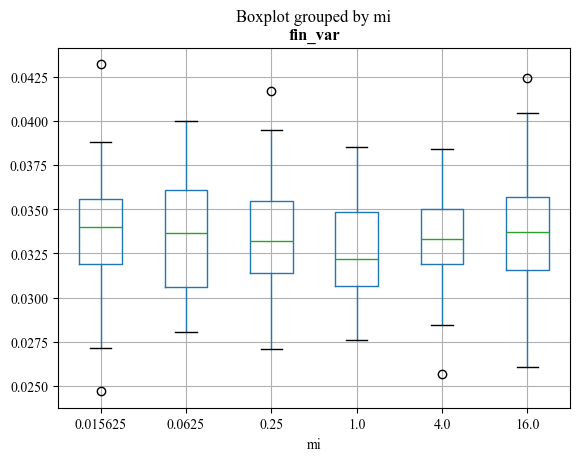

In [37]:
# tempdf boxplot per mi
tempdf.boxplot(column='fin_var', by='mi')

In [38]:
print("Variance/Stability of Queries [Count, Mean]")
saved_pac_variables_df.groupby('mi').agg({'fin_var': 'mean'})

Variance/Stability of Queries [Count, Mean]


,fin_var
mi,
0.015625,"[164.1671875, 0.03376903627221381]"
0.062500,"[162.303828125, 0.0334823642417733]"
0.250000,"[158.448125, 0.03340663214261741]"
1.000000,"[164.018671875, 0.03287335298149573]"
4.000000,"[162.90390625, 0.03330178080028557]"
16.000000,"[162.857578125, 0.03356437350125214]"


In [39]:
print("Variance of noise added to [Count, Mean] (scale param passed to Laplace noise function)")
saved_pac_variables_df.groupby('mi').agg({'pac_noise': 'mean'})

Variance of noise added to [Count, Mean] (scale param passed to Laplace noise function)


,pac_noise
mi,
0.015625,"[5328.524129985559, 76.25473914627028]"
0.062500,"[1317.0344903047776, 18.87172421871177]"
0.250000,"[321.4907094433032, 4.661272707588527]"
1.000000,"[83.16869818256595, 1.175798921556696]"
4.000000,"[20.65365010824261, 0.29482454959263665]"
16.000000,"[5.162200930836905, 0.07395050110256818]"


PAC: Variance of noise added to Mean (scale param passed to Laplace noise function)


<Axes: xlabel='mi'>

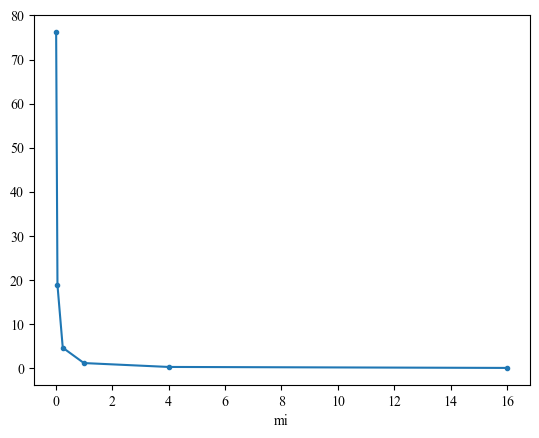

In [40]:
print("PAC: Variance of noise added to Mean (scale param passed to Laplace noise function)")
saved_pac_variables_df.groupby('mi').agg({'pac_noise': 'mean'})['pac_noise'].map(lambda x: x[1]).plot(marker='.')

In [41]:
dp_var_noise_a = [0.00390625, 0.0078125, 0.015625, 0.0625, 0.25, 1.0, 2.0, 4.0, 16.0]
dp_var_noise_b = [0.2784089313555703, 0.19648087910574175, 0.13837628104247293, 0.06750340282072995, 0.03001721300521553, 0.004282722801885366, 0.004282722801885366, 0.004282722801885366, 0.004282722801885366]

In [42]:
saved_pac_variables_df['out_np_0']

0      [322.0, 3.7950310559006213]
1       [318.0, 3.393081761006289]
2      [332.0, 3.7740963855421685]
3       [304.0, 3.898026315789474]
4      [329.0, 3.6686930091185412]
                  ...             
295     [309.0, 3.585760517799353]
296     [337.0, 3.798219584569733]
297    [321.0, 3.5576323987538943]
298     [329.0, 3.486322188449848]
299     [322.0, 3.527950310559006]
Name: out_np_0, Length: 300, dtype: object

In [43]:
true_result_no_sum = por_df['absences'].agg(['count', 'mean']).to_numpy()
saved_pac_variables_df['out_np_0']

0      [322.0, 3.7950310559006213]
1       [318.0, 3.393081761006289]
2      [332.0, 3.7740963855421685]
3       [304.0, 3.898026315789474]
4      [329.0, 3.6686930091185412]
                  ...             
295     [309.0, 3.585760517799353]
296     [337.0, 3.798219584569733]
297    [321.0, 3.5576323987538943]
298     [329.0, 3.486322188449848]
299     [322.0, 3.527950310559006]
Name: out_np_0, Length: 300, dtype: object

In [44]:
print("Difference between sampling error and noised error")
true_result_no_sum = por_df['absences'].agg(['count', 'mean']).to_numpy()
sampling_error = saved_pac_variables_df['out_np_0'].apply(pd.Series).rename(columns={0: 'count sampling error', 1: 'mean sampling error'})
noised_error = saved_pac_variables_df['pac_release'].apply(pd.Series).rename(columns={0: 'count noised error', 1: 'mean noised error'})
error_breakdown = pd.concat([saved_pac_variables_df, sampling_error, noised_error], axis=1).groupby('mi').agg({'count sampling error': 'mean', 'mean sampling error': 'mean', 'count noised error': 'mean', 'mean noised error': 'mean'})
error_breakdown

Difference between sampling error and noised error


,count sampling error,mean sampling error,count noised error,mean noised error
mi,,,,
0.015625,321.46,3.664255,809.858810,15.209873
0.062500,325.06,3.682813,1106.159805,5.491630
0.250000,322.00,3.671636,688.861065,3.816910
1.000000,323.32,3.660529,635.933357,3.773600
4.000000,323.02,3.629303,645.220579,3.663330
16.000000,325.36,3.625636,648.383700,3.624217


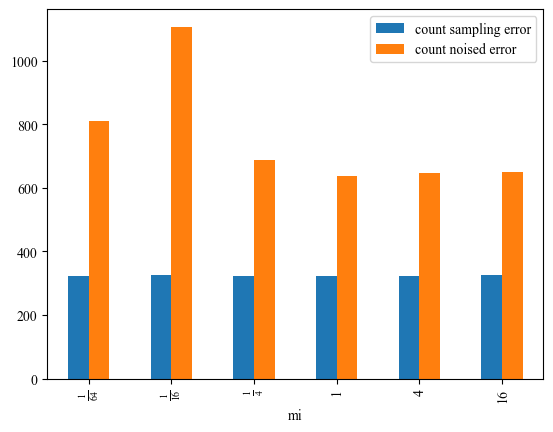

In [45]:
# plot sampling error vs noised error for count
fig, ax = plt.subplots()
error_breakdown.plot(y=['count sampling error', 'count noised error'], kind='bar', ax=ax)
xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in error_breakdown.index]
ax.set_xticklabels(xlabels)
plt.show()

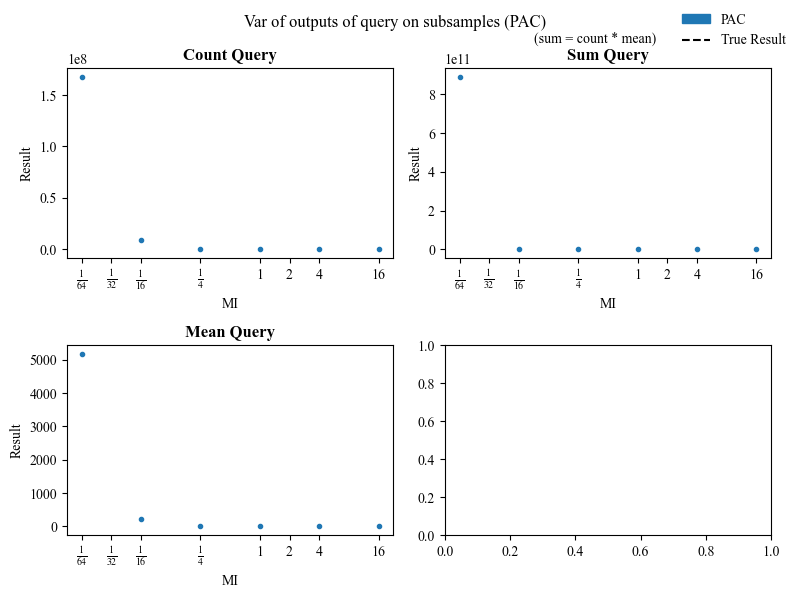

In [46]:
### Variance plot for PAC
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = OUTPUT_COLS
MI_OPTIONS = [1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    TYPE = 'pac'
    ax.scatter(df.groupby('mi').var().index, df.groupby('mi').var()[query], label=query, marker='.', color=PAC_COLOR)
    
    #ax.axhline(y=true_result[i], color='black', linestyle='--', label='True Result')

    #for mi in MI_OPTIONS:
        #d = df.iloc[:, [0, i]].where(df['mi'] == mi).dropna()
        #ax.scatter(d.iloc[:, 0], d.iloc[:, 1], label=query, marker='.', alpha=0.5, color=PAC_COLOR)
        #ax.boxplot(d.iloc[:, 1], positions=[mi], widths=0.1, showfliers=False)
    
    ax.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Line2D([0], [0], color='black', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')

fig.suptitle("Var of outputs of query on subsamples (PAC)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_pac.jpg", bbox_inches='tight')
plt.show()